## Auto Regression based SARIMA Model of CGM

#### Import necessary libraries

In [0]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
from pandas.plotting import autocorrelation_plot

In [4]:
data = pd.read_csv('CGMData.csv').T
data = data.reset_index(drop=True);
data = data.dropna()
data.shape

(43628, 1)

#### Plot Autocorrelation and Partial Autocorrelation to find the relationship between two objects

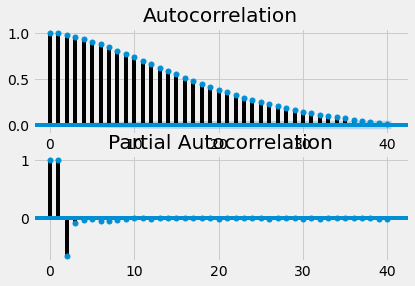

In [5]:
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(data, lags=40, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(data, lags=40, ax=ax[1])
plt.show()

#### Calculate relative quality of statistical models for a given data set using AIC estimator pick the combination which has minimum AIC value for training model.

In [ ]:
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(data,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))
        except: 
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:574347.5790607167
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:526944.9307503637
ARIMA(0, 0, 0)x(0, 0, 2, 12)12 - AIC:501076.88861111115
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:463652.88567043433
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:463173.9962082267


#### Dividing data into train and test data set and fit SARIMA model for prediction using walk forward validation technique

In [ ]:
def walk_forward_validation(data,n_test):
    predictions = pd.Series()
    train, test = data[:n_test],data[n_test:];
    model = sm.tsa.statespace.SARIMAX(train,
                                order=( 1 ,1, 2),
                                seasonal_order=(1, 0, 2, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False).fit();
    print(model.summary().tables[1])
    forecast = model.predict(len(train),len(train)+len(test)-1);
    print (forecast);
    predictions = pd.concat([predictions,forecast]);
    return predictions,test[0];

#### Calculate accuracy measurement of model using Mean Absolute Error, Mean Squared Error, Root Mean Squared Error

In [0]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt
def forecast_accuracy(forecast, actual):         
    mae =  mean_absolute_error(actual, forecast)   
    mse = mean_squared_error(actual, forecast)
    rmse = sqrt(mse)         
    return({
        'mae':mae,
        'mse':mse,
        'rmse':rmse
    })

In [41]:
train_size = int(len(data)*0.9);
predictions, test = walk_forward_validation(data, train_size)

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7190      0.004    182.387      0.000       0.711       0.727
ma.L1         -0.0964      0.004    -24.623      0.000      -0.104      -0.089
ar.S.L12       0.6007      0.117      5.114      0.000       0.370       0.831
ma.S.L12      -0.6190      0.115     -5.375      0.000      -0.845      -0.393
sigma2        24.9116      0.016   1549.028      0.000      24.880      24.943
39265    118.378617
39266    117.973687
39267    117.666736
39268    117.498463
39269    117.413626
            ...    
43623    117.837536
43624    117.837536
43625    117.837536
43626    117.837536
43627    117.837536
Length: 4363, dtype: float64


In [42]:
error = forecast_accuracy(predictions,test)
print (error)

{'mae': 57.351749798894, 'mse': 5699.807403895645, 'rmse': 75.49706884307261}
